In [13]:
import os
import sys

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from copy import deepcopy
from pprint import pprint

# set paths to various directories based on the machine this code is being executed on
with initialize(version_base=None, config_path='config'):
    config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleSkyPyLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import pyhalo, pandeia_input

In [14]:
output_dir = os.path.join(array_dir, 'change_background')
util.create_directory_if_not_exists(output_dir)

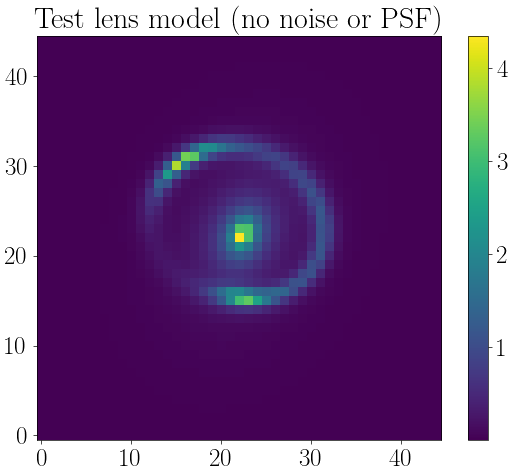

In [15]:
lens = SampleSkyPyLens()
model = lens.get_array(num_pix=45, side=4.95)

plot.plot(title='Test lens model (no noise or PSF)',
          array=model,
          colorbar=True)

In [16]:
num_samples = 10000

In [17]:
calc, _ = pandeia_input.build_pandeia_calc(array=model, 
                                        lens=lens, 
                                        band='f106', 
                                        num_samples=num_samples)

# turn all noise and effects off
calculation_dict = pandeia_input.get_calculation_dict(init=False)
calc['calculation'] = calculation_dict

  2%|▏         | 16/1065 [00:00<00:06, 152.42it/s]

100%|██████████| 1065/1065 [00:06<00:00, 162.25it/s]

Point source conversion complete: placed 1065 point sources
Estimated calculation time: 0:01:24


In [18]:
pprint(calc['background'])
pprint(calc['background_level'])
pprint(calc['calculation'])

'minzodi'
'benchmark'
{'effects': {'saturation': False},
 'noise': {'crs': False,
           'dark': False,
           'excess': False,
           'ffnoise': False,
           'readnoise': False,
           'scatter': False}}


# Does background change between images?

In [19]:
minzodi_calc = deepcopy(calc)
minzodi_calc['background'] = 'minzodi'
minzodi_calc['background_level'] = 'medium'

minzodi, execution_time = pandeia_input.get_pandeia_image(minzodi_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(output_dir, f'minzodi_medium_{num_samples}.npy'), minzodi)

Performing Pandeia calculation...
Pandeia calculation complete in 0:01:14
Execution time: 0:01:14


In [20]:
minzodi2_calc = deepcopy(calc)
minzodi2_calc['background'] = 'minzodi'
minzodi2_calc['background_level'] = 'medium'

minzodi2, execution_time = pandeia_input.get_pandeia_image(minzodi2_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(output_dir, f'minzodi2_medium_{num_samples}.npy'), minzodi2)

Performing Pandeia calculation...


Pandeia calculation complete in 0:01:15
Execution time: 0:01:15


In [21]:
minzodi3_calc = deepcopy(calc)
minzodi3_calc['background'] = 'minzodi'
minzodi3_calc['background_level'] = 'medium'

minzodi3, execution_time = pandeia_input.get_pandeia_image(minzodi3_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(output_dir, f'minzodi3_medium_{num_samples}.npy'), minzodi3)

Performing Pandeia calculation...
Pandeia calculation complete in 0:01:14
Execution time: 0:01:14


In [22]:
minzodi = np.load(os.path.join(output_dir, f'minzodi_medium_{num_samples}.npy'))
minzodi2 = np.load(os.path.join(output_dir, f'minzodi2_medium_{num_samples}.npy'))
minzodi3 = np.load(os.path.join(output_dir, f'minzodi3_medium_{num_samples}.npy'))

In [23]:
print(np.count_nonzero(minzodi - minzodi2))
print(np.count_nonzero(minzodi - minzodi3))

0
0


# Change background types

## Background: none

In [ ]:
none_calc = deepcopy(calc)
none_calc['background'] = 'none'

none, execution_time = pandeia_input.get_pandeia_image(none_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(output_dir, f'none_{num_samples}.npy'), none)

## Background: minzodi (background_level: benchmark (default))

In [ ]:
minzodi_calc = deepcopy(calc)
minzodi_calc['background'] = 'minzodi'
minzodi_calc['background_level'] = 'benchmark'

minzodi, execution_time = pandeia_input.get_pandeia_image(minzodi_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(output_dir, f'minzodi_{num_samples}.npy'), minzodi)

## Background: ecliptic

In [ ]:
ecliptic_calc = deepcopy(calc)
ecliptic_calc['background'] = 'ecliptic'
ecliptic_calc['background_level'] = 'medium'

ecliptic, execution_time = pandeia_input.get_pandeia_image(ecliptic_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(output_dir, f'ecliptic_{num_samples}.npy'), ecliptic)

## Compare background types

In [ ]:
none = np.load(os.path.join(output_dir, f'none_{num_samples}.npy'))
minzodi = np.load(os.path.join(output_dir, f'minzodi_{num_samples}.npy'))
ecliptic = np.load(os.path.join(output_dir, f'ecliptic_{num_samples}.npy'))

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(12, 8))

# array_list = [pandeia - crs_off, pandeia - dark_off, pandeia - ffnoise_off, pandeia - readnoise_off, pandeia - scatter_off, pandeia - saturation_off]

ax0 = ax[0,0].imshow(minzodi, cmap='viridis')
ax[0,0].set_title('Minzodi (level: benchmark)')

ax1 = ax[0,1].imshow(ecliptic, cmap='viridis')
ax[0,1].set_title('Ecliptic (level: medium)')

ax2 = ax[0,2].imshow(none, cmap='viridis')
ax[0,2].set_title('None')

ax3 = ax[1,0].imshow(none - minzodi, cmap='bwr')
ax[1,0].set_title('Residuals: None - Minzodi')

ax4 = ax[1,1].imshow(none - ecliptic, cmap='bwr')
ax[1,1].set_title('Residuals: None - Ecliptic')

ax[1,2].remove()

# fig.colorbar(ax0, ax=[ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2]])

# plt.savefig(os.path.join(figure_dir, 'noise_asinh.png'))
plt.show()

# Change background level (Minzodi)

## Background level: benchmark (default)

In [ ]:
# this was calculated above, so just load it below
minzodi = np.load(os.path.join(output_dir, f'minzodi_{num_samples}.npy'))

## Background level: high

In [ ]:
minzodi_high_calc = deepcopy(calc)
minzodi_high_calc['background'] = 'minzodi'
minzodi_high_calc['background_level'] = 'high'

minzodi_high, execution_time = pandeia_input.get_pandeia_image(minzodi_high_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(output_dir, f'minzodi_high_{num_samples}.npy'), minzodi_high)

## Background level: medium

In [ ]:
minzodi_medium_calc = deepcopy(calc)
minzodi_medium_calc['background'] = 'minzodi'
minzodi_medium_calc['background_level'] = 'medium'

minzodi_medium, execution_time = pandeia_input.get_pandeia_image(minzodi_medium_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(output_dir, f'minzodi_medium_{num_samples}.npy'), minzodi_medium)

## Background level: low

In [ ]:
minzodi_low_calc = deepcopy(calc)
minzodi_low_calc['background'] = 'minzodi'
minzodi_low_calc['background_level'] = 'low'

minzodi_low, execution_time = pandeia_input.get_pandeia_image(minzodi_low_calc)
print(f'Execution time: {execution_time}')

np.save(os.path.join(output_dir, f'minzodi_low_{num_samples}.npy'), minzodi_low)

## Compare background levels

In [ ]:
minzodi_benchmark = np.load(os.path.join(output_dir, f'minzodi_{num_samples}.npy'))
minzodi_high = np.load(os.path.join(output_dir, f'minzodi_high_{num_samples}.npy'))
minzodi_medium = np.load(os.path.join(output_dir, f'minzodi_medium_{num_samples}.npy'))
minzodi_low = np.load(os.path.join(output_dir, f'minzodi_low_{num_samples}.npy'))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20, 4))

ax0 = ax[0].imshow(minzodi_benchmark, cmap='viridis')
ax[0].set_title('Benchmark')

ax1 = ax[1].imshow(minzodi_high, cmap='viridis')
ax[1].set_title('High')

ax2 = ax[2].imshow(minzodi_medium, cmap='viridis')
ax[2].set_title('Medium')

ax3 = ax[3].imshow(minzodi_low, cmap='viridis')
ax[3].set_title('Low')

# fig.colorbar(ax0, ax=[ax[0,0], ax[0,1], ax[0,2], ax[1,0], ax[1,1], ax[1,2]])

# plt.savefig(os.path.join(figure_dir, 'noise_asinh.png'))
plt.show()